# Differential correlation analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get canonical TFs

In [7]:
tf_df = pd.read_csv('../baseline/human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA']

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [8]:
# adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [9]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [10]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [12]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [13]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [14]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [15]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

Version 0.0.6


In [16]:
isg_classes = pd.read_csv('../isg_classes.csv')

In [17]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0]

### Read 1d HT result comparing to control

In [18]:
cts = [['ciliated']]
tps = [ '6',]
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [19]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read(data_path + '/binary_test_latest/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [20]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

In [21]:
stims = ['alpha', 'beta', 'gamma', 'lambda']
ct = 'ciliated'
de_genes  = {}
for stim in stims:
    de_genes[stim] = all_result[ct]['ht'][stim]['6'].query('de_fdr < 0.1 & de_coef > 0.5').gene.tolist()
de_genes['alpha/beta'] = set(de_genes['alpha']) | set(de_genes['beta'])

stims = ['gamma', 'lambda', 'alpha/beta']
    
uniq_de_genes = {}
for stim in stims:
    
    uniq_de_genes[stim] = set(de_genes[stim])
    for other in stims:
        if stim == other: continue
        uniq_de_genes[stim] -= set(de_genes[other])
    print(stim, len(uniq_de_genes[stim]))

shared_de_genes = set()
for stim in stims:
    if len(shared_de_genes) == 0:
        shared_de_genes = set(de_genes[stim])
    else:
        shared_de_genes &= set(de_genes[stim])

all_de_genes = set()
for stim in ['alpha', 'beta', 'gamma', 'lambda']:
    all_de_genes |= set(de_genes[stim])
shared_de_genes_lenient = all_de_genes - shared_de_genes
for stim in ['gamma', 'lambda', 'alpha/beta']:
    shared_de_genes_lenient -= uniq_de_genes[stim]

gamma 53
lambda 21
alpha/beta 389


### Run adjusting for STAT1

In [20]:
# First, get correlations without adjustment
stim = 'beta'
ct = ['C']
adata_stim = adata.copy()[

    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin([stim])].copy()

adata_stim.obs['group'] = 1
# adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
# adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)#.apply(lambda x: time_converter[x])

memento.create_groups(adata_stim, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
# moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

available_tfs = list(set(tf_list) & set(adata_stim.var.index))
available_isgs= list(set(t1_isg+t2_isg+shared_isg) & set(adata_stim.var.index))

memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_isgs)))

moment_df = memento.get_2d_moments(adata_stim, groupby='group')
candidates = moment_df.query('group_1 > 0.35')
memento.compute_2d_moments(adata_stim, list(zip(candidates['gene_1'], candidates['gene_2'])))

memento.ht_2d_moments( 
    adata_stim, 
    formula_like='1 + donor',
    treatment_col='Inter', 
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False)

rho = memento.get_2d_ht_result(adata_stim)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.8s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   10.8s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   16.0s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   25.3s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:   35.2s
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:   50.0s
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:  1.1min
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:  1.4min
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:  1.7min
[Parallel(n_jobs=94)]: Done 5862 tasks      | elapsed:  2.1min
[Parallel(n_jobs=94)]: Done 7012 tasks      | elapsed:  2.5min
[Parallel(n_jobs=94)]: Done 72

In [22]:
# Adjust for STAT1
stim = 'gamma'
ct = ['C']
adata_stim = adata.copy()[

    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin([stim])].copy()

adata_stim.obs['group'] = 1
adata_stim.obs['med_expr'] = pd.qcut(pd.Series(adata_stim[:, 'STAT1'].X.todense().A1), q=4, labels=range(4),duplicates='raise').values

memento.create_groups(adata_stim, label_columns=['donor', 'group', 'med_expr'])
memento.compute_1d_moments(adata_stim, min_perc_group=.7)
# moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

available_genes = adata_stim.var.index.tolist()

candidates = candidates.query('gene_1 in @available_genes & gene_2 in @available_genes')
print(candidates.shape)


memento.compute_2d_moments(adata_stim, list(zip(candidates['gene_1'], candidates['gene_2'])))

memento.ht_2d_moments( 
    adata_stim, 
    formula_like='1 + donor + med_expr',
    treatment_col='Inter', 
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False)

rho_adj = memento.get_2d_ht_result(adata_stim)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(6445, 3)


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    5.3s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   13.2s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   21.4s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   34.2s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:   51.0s
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:  1.2min
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:  1.6min
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:  2.0min
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:  2.5min
[Parallel(n_jobs=94)]: Done 5862 tasks      | elapsed:  3.0min
[Parallel(n_jobs=94)]: Done 6391 out of 6391 | elapsed:  3.3min finished


In [23]:
merged_rho = rho.merge(rho_adj, on=['gene_1', 'gene_2'], suffixes=('', '_adj'))
merged_rho['diff'] = merged_rho['corr_coef'] - merged_rho['corr_coef_adj']
merged_rho['diff_se'] = np.sqrt(merged_rho['corr_se']**2 + merged_rho['corr_se_adj']**2).values

In [29]:
moment_df.query('gene_1 == "CIITA"').sort_values('group_1', ascending=False)

,gene_1,gene_2,group_1
220623,CIITA,CIITA,0.999999
220556,CIITA,TAP1,0.632307
220362,CIITA,APOL6,0.632215
220672,CIITA,GBP1,0.620546
220750,CIITA,XRN1,0.608756
220690,CIITA,NLRC5,0.605857
220369,CIITA,PARP14,0.589824
220512,CIITA,JAK2,0.571051
220557,CIITA,PARP9,0.570488
220477,CIITA,SCO2,0.552947


In [27]:
merged_rho.sort_values('corr_coef_adj', ascending=False).query('gene_1 == "CIITA"')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_coef_adj,corr_se_adj,corr_pval_adj,diff,diff_se
4327,CIITA,TAP1,0.632307,0.039727,4.164909e-08,0.578078,0.047689,1.890342e-05,0.054229,0.062068
4299,CIITA,APOL6,0.632215,0.039908,3.807583e-06,0.571342,0.047564,5.496987e-06,0.060873,0.062088
4351,CIITA,GBP1,0.620546,0.031528,4.905035e-05,0.560031,0.036332,1.125108e-05,0.060515,0.048104
4364,CIITA,XRN1,0.608756,0.049868,4.201300e-05,0.551292,0.058483,2.882102e-05,0.057463,0.076858
4316,CIITA,SCO2,0.552947,0.043829,1.356364e-04,0.534840,0.051707,4.073826e-06,0.018106,0.067783
4301,CIITA,PARP14,0.589824,0.033413,2.372381e-06,0.531450,0.039756,5.461775e-06,0.058373,0.051933
4293,CIITA,BCL2L14,0.521725,0.075759,6.694846e-04,0.509375,0.082194,3.212305e-05,0.012350,0.111782
4336,CIITA,MMP25-AS1,0.519594,0.056132,7.589114e-06,0.506394,0.062584,6.532218e-06,0.013201,0.084069
4356,CIITA,NLRC5,0.605857,0.066742,8.967394e-06,0.501742,0.075168,2.690027e-05,0.104114,0.100522
4320,CIITA,JAK2,0.571051,0.069428,4.290321e-05,0.500243,0.082499,2.567944e-04,0.070808,0.107825


In [24]:
merged_rho.query('gene_1 == "IRF1"').sort_values('diff', ascending=False)`

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_coef_adj,corr_se_adj,corr_pval_adj,diff,diff_se
795,IRF1,UBE2L6,0.369620,0.023099,1.364622e-05,0.199907,0.028522,0.000267,0.169713,0.036702
772,IRF1,GSTK1,0.352468,0.031836,1.796543e-05,0.188382,0.041664,0.001245,0.164085,0.052435
777,IRF1,PSMB8,0.378378,0.020216,3.748931e-05,0.214465,0.024664,0.000025,0.163914,0.031890
810,IRF1,GBP3,0.353127,0.026991,3.659133e-06,0.201890,0.033171,0.000048,0.151237,0.042765
784,IRF1,PARP9,0.436629,0.025271,9.113341e-07,0.291686,0.032200,0.000030,0.144944,0.040932
787,IRF1,PSMB9,0.402776,0.017579,3.335270e-05,0.259081,0.020992,0.000007,0.143695,0.027381
791,IRF1,PLAAT4,0.353009,0.017359,2.702799e-06,0.209777,0.019384,0.000003,0.143232,0.026020
804,IRF1,TRIM22,0.362177,0.027019,3.117428e-06,0.228064,0.037177,0.000102,0.134113,0.045958
773,IRF1,IFI35,0.389309,0.029944,2.301894e-06,0.260108,0.037776,0.000167,0.129201,0.048205
783,IRF1,TAP1,0.485408,0.024702,4.020792e-06,0.356665,0.030818,0.000006,0.128742,0.039495


In [ ]:
merged_rho.head(2)

In [ ]:
rho_adj

In [44]:
delta

array([ 0.08657027,  0.17231988, -0.01092697, ...,         nan,
               nan,         nan])

In [ ]:
for tf in (set(de_genes['gamma'])&set(tf_list)):
    
    if tf in ['STAT1', 'ATF3'] or tf in adj_results: continue
    
    delta, se = adjust(tf)
    pv = stats.norm.sf(delta, loc=0, scale=se)
    adj_results[tf] = (delta, se, pv)

In [79]:
def adjust(mediator):
        
    adata_stim = adata.copy()[

        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin([stim])].copy()
    
    adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)#.apply(lambda x: time_converter[x])

    adata_stim.obs['med_expr'] = adata_stim[:, mediator].X.todense().A1
    memento.create_groups(adata_stim, label_columns=['donor', 'med_expr'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.5)
    # moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], c2_genes)))

    # moment_df = memento.get_2d_moments(adata_stim, groupby='is_stim')

    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + donor + med_expr',
        treatment_col='Inter', 
        num_boot=10000, 
        verbose=0,
        num_cpus=94,
        resampling='permutation',
        approx=False)

    rho_adj = memento.get_2d_ht_result(adata_stim)
    
    return (rho['corr_coef'] - rho_adj['corr_coef']).values, np.sqrt(rho['corr_se']**2 + rho_adj['corr_se']**2).values

In [80]:
delta, se = adjust('CIITA')
print(stats.norm.sf(delta, loc=0, scale=se))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


[0.02957654 0.07684802 0.0303681  0.18115575 0.12129824 0.11322488
 0.14126288]


In [86]:
for tf in (set(de_genes['gamma'])&set(tf_list)):
    
    if tf in ['STAT1', 'ATF3'] or tf in adj_results: continue
    
    delta, se = adjust(tf)
    pv = stats.norm.sf(delta, loc=0, scale=se)
    adj_results[tf] = (delta, se, pv)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in

In [90]:
result_df = []
for tf, val in adj_results.items():
    
    a = pd.DataFrame()
    a['gene'] = c2_genes
    a['se'] = val[1]
    a['delta_rho'] = val[0]
    a['pv'] = val[2]
    a['tf'] = tf
    result_df.append(a)
result_df = pd.concat(result_df)

<AxesSubplot:xlabel='delta_rho', ylabel='tf'>

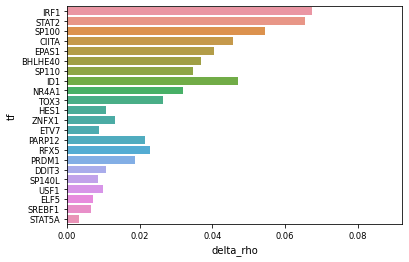

In [101]:
sns.barplot(y='tf', x='delta_rho', data=result_df.sort_values('delta_rho', ascending=False), errwidth=0)

Text(0.5, 0, '$\\Delta\\rho_{\\mathrm{ADJ}} - \\Delta\\rho$')

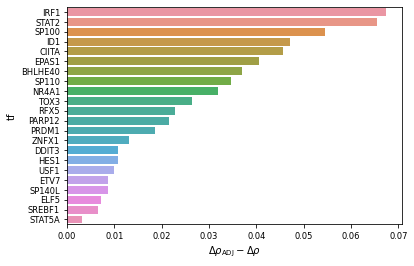

In [119]:
sns.barplot(y='tf', x='delta_rho', data=result_df.groupby('tf')['delta_rho'].mean().sort_values(ascending=False).reset_index(name='delta_rho'))
plt.xlabel(r'$\Delta\rho_{\mathrm{ADJ}} - \Delta\rho$')

In [120]:
pv = result_df.groupby('tf')['pv'].apply(lambda x: stats.combine_pvalues(x)[1]).sort_values()

In [123]:
fdr = memento.util._fdrcorrect(pv)

In [124]:
fdr

array([7.55244762e-05, 7.55244762e-05, 1.10957744e-03, 6.23741967e-03,
       6.23741967e-03, 1.32869976e-02, 2.27980676e-02, 4.69593632e-02,
       4.90070567e-02, 1.49024080e-01, 2.22171945e-01, 2.84743085e-01,
       3.56540155e-01, 5.81178396e-01, 5.81178396e-01, 5.81178396e-01,
       5.81178396e-01, 5.81178396e-01, 5.88793778e-01, 6.23966965e-01,
       6.29748894e-01, 6.87918333e-01])

In [63]:
delta, se = adjust('JUNB')
print(stats.norm.sf(delta, loc=0, scale=se))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   4 out of   7 | elapsed:    2.7s remaining:    2.0s
[Parallel(n_jobs=94)]: Done   7 out of   7 | elapsed:    3.8s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   4 out of   7 | elapsed:   10.0s remaining:    7.5s


[0.16144843 0.21353627 0.20754591 0.15573289 0.34621325 0.30872167
 0.52620379]


[Parallel(n_jobs=94)]: Done   7 out of   7 | elapsed:   14.5s finished


In [62]:
delta, se = adjust('CIITA')
print(stats.norm.sf(delta, loc=0, scale=se))

array([0.03102337, 0.07709145, 0.03047889, 0.1810527 , 0.11786292,
       0.10992212, 0.13843179])

### Run differential correlation between STAT1 and each stim's DEGs

In [22]:
ct = ['ciliated']
all_stims = ['gamma', 'lambda', 'alpha', 'beta']

In [91]:
for stim in all_stims:
    
    print('starting ', stim, '....')

    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    
    # time_converter={0:0, int('6'):1}
    adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.3)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

#     available_tfs = list(set(tf_list) & set(moment_1d_df[0].gene))
    available_targets = list(set(de_genes[stim if stim not in ['alpha', 'beta'] else 'alpha/beta']) & set(moment_1d_df[0].gene))

    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_targets)))

#     moment_df = memento.get_2d_moments(adata_stim, groupby='time') 

#     moment_df['max_corr'] = moment_df.iloc[:, 2:].max(axis=1).values

#     candidates = moment_df.query('max_corr > 0.3 & gene_1 != gene_2')

# #     top_tfs = candidates.groupby('gene_1').size().sort_values(ascending=False)
# #     top_tfs = top_tfs[top_tfs > 15].index.tolist()

# #     candidates = candidates.query('gene_1 in @top_tfs')

#     candidates = list(zip(candidates['gene_1'], candidates['gene_2']))

#     memento.compute_2d_moments(adata_stim, candidates)

    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + time + donor',
        treatment_col='time', 
        num_boot=10000, 
        verbose=1,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    
    adata_stim.write(data_path + 'stat1_coex_test/{}.h5ad'.format(stim))


starting  gamma ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

starting  lambda ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done 198 o

starting  alpha ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

starting  beta ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

In [ ]:
for stim in all_stims:
        
    print('starting ', stim, '....')

    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    
    time_converter={'0':0, '3':1, '6':2, '9':3, '24':4, '48':5}
    adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)#.apply(lambda x: time_converter[x])
    adata_stim.obs['is_stim'] = (adata_stim.obs.stim==stim).astype(int)

    memento.create_groups(adata_stim, label_columns=['is_stim','time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.3)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

    available_targets = list(set(de_genes[stim]) & set(moment_1d_df[0].gene))

    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_targets)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time') 

#     moment_df['max_corr'] = moment_df.iloc[:, 2:].max(axis=1).values

#     candidates = moment_df.query('max_corr > 0.3 & gene_1 != gene_2')

#     candidates = list(zip(candidates['gene_1'], candidates['gene_2']))

#     memento.compute_2d_moments(adata_stim, candidates)
    
    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + is_stim + donor',
        treatment_col='is_stim', 
        num_boot=10000, 
        verbose=1,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    
    adata_stim.write(data_path + 'stat1_coex_test/{}_linear.h5ad'.format(stim))


starting  gamma ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

starting  lambda ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarn

### Read DC results

In [80]:
def classify(x):
    
    if x in shared_de_genes:
        return 'shared'
    elif x in shared_de_genes_lenient:
        return 'partially_shared'
    for stim in stims:
        if x in uniq_de_genes[stim]:
            return 'uniq_' + stim
    return 'none-DE'

In [145]:
deg_dc_results = {}
deg_2d_moments = {}
deg_m_moments = {}
deg_v_moments = {}
combined_results = {}

for stim in all_stims:
    
    adata_stim = sc.read(data_path + 'stat1_coex_test/{}_linear.h5ad'.format(stim))
    deg_dc_results[stim] = memento.get_2d_ht_result(adata_stim)
    deg_2d_moments[stim] = memento.get_2d_moments(adata_stim, groupby='time')[['gene_1','gene_2'] + ['time_'+str(i) for i in [0, 1, 2, 3, 4, 5]]]
#     deg_m_moments[stim],deg_v_moments[stim] = memento.get_1d_moments(adata_stim, groupby='time')
#     deg_m_moments[stim] = deg_m_moments[stim][['gene'] + ['time_'+str(i) for i in [0, 3, 6, 9, 24, 48]]]
#     deg_v_moments[stim] = deg_v_moments[stim][['gene'] + ['time_'+str(i) for i in [0, 3, 6, 9, 24, 48]]]
    deg_dc_results[stim]['corr_fdr'] = memento.util._fdrcorrect(deg_dc_results[stim]['corr_pval'])
    
    combined_results[stim] = deg_2d_moments[stim].merge(deg_dc_results[stim], on=['gene_1', 'gene_2'])
    combined_results[stim]['deg_type'] = combined_results[stim]['gene_2'].apply(classify)
    combined_results[stim]['sig'] =  (combined_results[stim]['corr_fdr'] < 0.05) & (combined_results[stim]['corr_coef'] > 0.0)
    
   

### Differential correlation and sharedness

In [146]:
a = deg_dc_results['lambda']

In [147]:
a['is_uniq'] = a['gene_2'].isin(uniq_de_genes['lambda'])

In [150]:
combined_results['lambda'].sort_values('corr_coef', ascending=False)

,gene_1,gene_2,time_0,time_1,time_2,time_3,time_4,time_5,corr_coef,corr_se,corr_pval,corr_fdr,deg_type,sig
152,STAT1,GSTA4,-0.114069,0.216478,0.216478,0.217556,0.221651,0.235981,0.103536,0.022920,0.000222,0.011313,uniq_lambda,True
9,STAT1,ZYX,-0.072388,0.078469,0.078469,0.073202,0.045811,0.127582,0.100967,0.032542,0.003100,0.013949,uniq_lambda,True
52,STAT1,CTDSP1,-0.265068,0.128000,0.128000,0.152787,0.106809,0.178078,0.091377,0.037092,0.013799,0.044789,partially_shared,True
189,STAT1,CHPT1,-0.139704,0.128094,0.128094,0.139944,0.177663,0.148499,0.089075,0.023753,0.000686,0.011313,uniq_lambda,True
153,STAT1,MYC,-0.130424,0.099678,0.099678,0.089579,0.108588,0.131956,0.088699,0.022932,0.000636,0.011313,uniq_lambda,True
94,STAT1,F3,-0.074340,0.115347,0.115347,0.154803,0.093805,0.168025,0.086685,0.012815,0.000340,0.011313,shared,True
76,STAT1,ATP6V1C2,-0.080710,0.131857,0.131857,0.132558,0.147808,0.145928,0.084827,0.030022,0.006499,0.024748,shared,True
74,STAT1,SLC16A9,-0.022098,0.178907,0.178907,0.235420,0.124071,0.243805,0.083314,0.024766,0.001700,0.011436,partially_shared,True
55,STAT1,TOR1B,0.111860,0.352982,0.352982,0.381142,0.370164,0.373865,0.082824,0.034430,0.015898,0.050772,partially_shared,False
7,STAT1,VEGFA,-0.018837,0.129133,0.129133,0.143994,0.109418,0.147115,0.080101,0.018003,0.000309,0.011313,shared,True


In [138]:
deg_dc_results['lambda']#.query('deg_type=="shared"')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr,deg_type,sig,is_uniq
0,STAT1,FUT2,0.027354,0.026838,0.301670,0.455959,shared,False,False
1,STAT1,SP100,-0.025332,0.019409,0.191181,0.337980,shared,False,False
2,STAT1,U62317.4,-0.023812,0.019326,0.216178,0.365840,shared,False,False
3,STAT1,NIBAN1,0.055524,0.019968,0.005799,0.022966,partially_shared,True,False
4,STAT1,PARP14,0.037395,0.012909,0.003700,0.015924,shared,True,False
5,STAT1,VWA1,0.059357,0.033733,0.077392,0.178182,partially_shared,False,False
6,STAT1,DDIT4,0.022083,0.012699,0.082092,0.186830,partially_shared,False,False
7,STAT1,VEGFA,0.080101,0.018003,0.000309,0.011313,shared,True,False
8,STAT1,PIM3,0.041044,0.018885,0.028397,0.081488,shared,True,False
9,STAT1,ZYX,0.100967,0.032542,0.003100,0.013949,uniq_lambda,True,True


In [120]:
for stim in all_stims:
    
    contingency = pd.crosstab(
        deg_dc_results[stim]['deg_type']=='shared', 
        deg_dc_results[stim]['sig'])
    print(stim)
    print(contingency)
    print(stim, stats.fisher_exact(contingency))

gamma
sig       False  True 
deg_type              
False        80    128
True         54     58
gamma (0.6712962962962963, 0.09758328740019982)
lambda
sig       False  True 
deg_type              
False        53     34
True         75     37
lambda (0.7690196078431373, 0.4559317190052937)
alpha
sig       False  True 
deg_type              
False       223    220
True         34     67
alpha (1.9974598930481284, 0.002785560119163853)
beta
sig       False  True 
deg_type              
False       247    281
True         23     89
beta (3.40136159678168, 1.7453076407822353e-07)


In [82]:
ht_2d_df = memento.get_2d_ht_result(adata_stim)
ht_2d_df['corr_fdr'] = memento.util._fdrcorrect(ht_2d_df['corr_pval'])
sig_df = ht_2d_df.query('corr_fdr < 0.1')

In [83]:
tp_order = ['time_tp_' + str(i) for i in [0, 3, 6, 9, 24, 48]]

In [90]:
moment_1d_df[0].query('gene == "CIITA"')[tp_order]

,time_tp_0,time_tp_3,time_tp_6,time_tp_9,time_tp_24,time_tp_48
8497,-2.216917,-0.133482,-0.250962,-0.205729,-0.256063,-0.471048


In [85]:
dra=moment_df.merge(sig_df[['gene_1', 'gene_2']], on=['gene_1', 'gene_2'], how='inner')\
    .query('gene_2.str.startswith("HLA-DRA")', engine='python')[['gene_1', 'gene_2'] + tp_order]

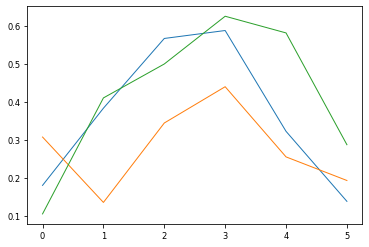

In [86]:
plt.plot(dra[tp_order].values.T, lw=1);